### Loading modules

In [1]:
import os, sys
sys.path.append(os.path.abspath('../scripts'))

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed

import utils as ut
import plot as pt


warnings.filterwarnings("ignore")

In [3]:
all_data_path = '../data/raw_analyst_ratings.csv'
df = ut.read_csv_file(all_data_path)

In [4]:
df = df.get("data")
df.sample(10)

,headline,url,publisher,date,stock
300914,Shares of many oil and gas companies are tradi...,https://www.benzinga.com/markets/wiim/19/05/13...,Benzinga Newsdesk,2019-05-22 00:00:00,CRZO
1404680,Why Did InvenSense Rise 113% Since its IPO?,https://www.benzinga.com/trading-ideas/long-id...,Louis Bedigian,2012-02-13 00:00:00,ZNGA
519678,"Fuel Systems Solutions, Inc. Reports Q1 EPS of...",https://www.benzinga.com/news/earnings/13/05/3...,Charles Gross,2013-05-08 00:00:00,FSYS
297075,salesforce.com Sees Q2 Adj. EPS $0.24-$0.25 vs...,https://www.benzinga.com/news/16/05/8003295/sa...,Paul Quintaro,2016-05-18 00:00:00,CRM
663528,Raymond James Upgrades Infinera to Market Perform,https://www.benzinga.com/news/19/08/14228219/r...,Vick Meyer,2019-08-08 00:00:00,INFN
766847,"Fewer than 1,000 Lockheed Martin Jobs to be Cr...",https://www.benzinga.com/news/18/10/12588941/f...,Charles Gross,2018-10-30 00:00:00,LMT
1138411,Pre-Thanksgiving Earnings Previews: Campbell S...,https://www.benzinga.com/news/earnings/12/11/3...,Nelson Hem,2012-11-17 00:00:00,SJM
696131,Credit Suisse Upgrades JC Penney Co to Neutral...,https://www.benzinga.com/news/16/01/6184924/cr...,Eddie Staley,2016-01-29 00:00:00,JCP
378262,"Cramer Says Up To 1 Out Of 3 Restaurants, Bars...",https://www.benzinga.com/general/restaurants/2...,Jayson Derrick,2020-05-06 00:00:00,DRI
1274630,Market Wrap For May 1: Markets Mixed To Start ...,https://www.benzinga.com/news/earnings/14/05/4...,Jayson Derrick,2014-05-01 00:00:00,TXT


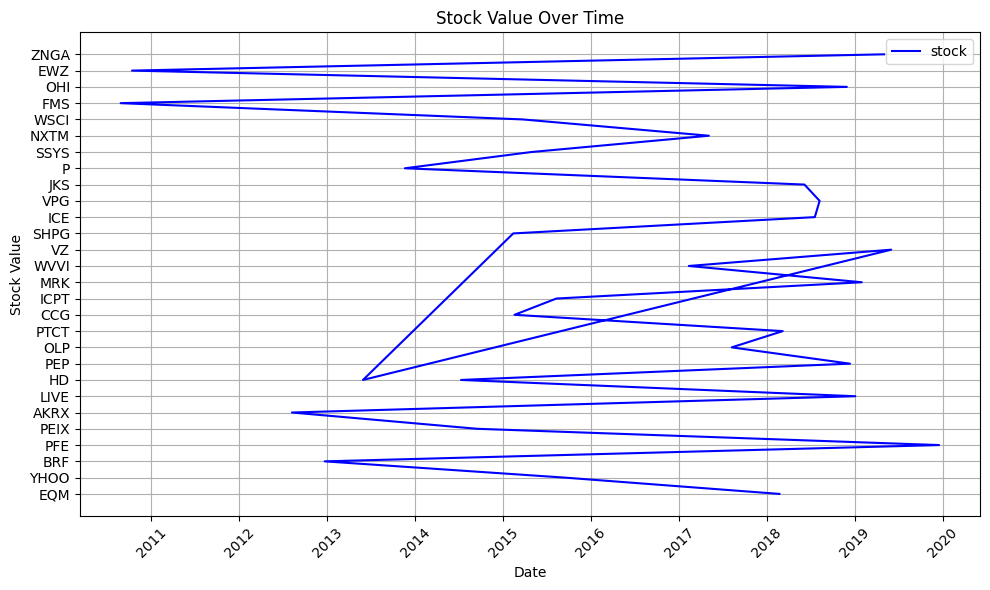

In [5]:
temp = df.sample(30)
pt.plot_stock_data(temp, date_column='date', stock_value_column='stock')

### Descriptive Statistics

In [6]:
df['headline_chr_length'] = df['headline'].apply(lambda x: len(x))
df['headline_word_length'] = df['headline'].apply(lambda x: len(x.split()))

#  statistics summary
display(
    "Summary statistics for headline character and word lengths",
    df[['headline_chr_length', 'headline_word_length']].describe().astype(int)
)

'Summary statistics for headline character and word lengths'

,headline_chr_length,headline_word_length
count,1407328,1407328
mean,73,11
std,40,6
min,3,1
25%,47,7
50%,64,10
75%,87,13
max,512,77


In [7]:
# let's see the extreme values

display(
    "Headline with maximum character length",
    df.loc[df['headline_chr_length'].idxmax(), 'headline'],

    "Headline with maximum word length",
    df.loc[df['headline_word_length'].idxmax(), 'headline'],

    "Headline with minimum character length",
    df.loc[df['headline_chr_length'].idxmin(), 'headline'],

    "Headline with minimum word length",
    df.loc[df['headline_word_length'].idxmin(), 'headline']
)

'Headline with maximum character length'

'JinkoSolar Tiger Pro Series Receives World\'s First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in the world, today announced that its innovative Tiger Pro Series of high-efficiency modules received the world\'s first IEC 61701 Ed. 3 (FDIS) certification for salt mist corrosion test issued by TÜV Nord AG, an independent provider of technical ser'

'Headline with maximum word length'

'JinkoSolar Tiger Pro Series Receives World\'s First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in the world, today announced that its innovative Tiger Pro Series of high-efficiency modules received the world\'s first IEC 61701 Ed. 3 (FDIS) certification for salt mist corrosion test issued by TÜV Nord AG, an independent provider of technical ser'

'Headline with minimum character length'

'SPY'

'Headline with minimum word length'

'Accenture'

In [8]:
# Count the number of articles per publisher to identify which publishers are most active.

publisher_counts = df['publisher'].value_counts()
publisher_counts = publisher_counts.reset_index()

publisher_counts.columns = ['publisher', 'article_count']

display(
    "Total number of publishers",
    len(publisher_counts),

    "Publisher with most articles",
    publisher_counts.head(10),
    "Publisher with least articles",
    publisher_counts.tail(10)
)   

'Total number of publishers'

1034

'Publisher with most articles'

,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


'Publisher with least articles'

,publisher,article_count
1024,GeoInvesting,1
1025,Tom Kee,1
1026,Greg W. Harmon,1
1027,TradingPub,1
1028,Ethan Joseph,1
1029,Matthew Ely,1
1030,Frank Ochoa,1
1031,Jeremie Capron,1
1032,Marvin Dumont,1
1033,Igor Gonta,1


In [9]:
# Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

x = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
x[~x.isna()] = x[~x.isna()].dt.tz_localize(None)
x.fillna(pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce'), inplace=True)

df['date'] = x

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Count the number of articles per year and month
year_counts = df['year'].value_counts().reset_index()
year_counts.columns = ['year', 'article_count']

month_counts = df['month'].value_counts().reset_index()
month_counts.columns = ['month', 'article_count']

display(
    "Number of articles per year",
    year_counts,

    "Number of articles per month",
    month_counts
)

'Number of articles per year'

,year,article_count
0,2019,150380
1,2018,146924
2,2016,141892
3,2015,135295
4,2014,134859
5,2011,131322
6,2017,124456
7,2012,122655
8,2013,121523
9,2020,105214


'Number of articles per month'

,month,article_count
0,5,130339
1,10,124800
2,8,124042
3,2,122835
4,3,121948
5,4,121815
6,1,121541
7,11,121431
8,7,110762
9,6,106600


In [10]:
# Looking for particular days or during specific events where the news frequency is high

df['day'] = df['date'].dt.day
day_cols = ['year', 'month', 'day']

df.groupby(day_cols).size().reset_index(name='article_count').sort_values('article_count', ascending=False).head(10)

,year,month,day,article_count
3863,2020,3,12,2739
3850,2020,2,28,1620
3870,2020,3,19,1594
3849,2020,2,27,1567
3857,2020,3,6,1428
3919,2020,5,7,1396
3874,2020,3,23,1390
3911,2020,4,29,1389
3862,2020,3,11,1384
3912,2020,4,30,1327


In [11]:
# Perform sentiment analysis on headlines to gauge the sentiment (positive, negative, neutral) associated with the news.

results = Parallel(n_jobs=-1)(
    delayed(ut.get_sentiment)(text) for text in df['headline']
)

df['sentiment'] = results

# classify sentiment into positive, negative, and neutral
df['sentiment_class'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

sentiment_counts = df['sentiment_class'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment_class', 'article_count']

display(
    "Sentiment counts",
    sentiment_counts
)

'Sentiment counts'

,sentiment_class,article_count
0,neutral,934914
1,positive,341178
2,negative,131236


In [15]:
# Use natural language processing to identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.).

cv = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=50)

word_freq_matrix = cv.fit_transform(df['headline'])

word_freq = word_freq_matrix.sum(axis=0)

word_freq_df = pd.DataFrame({
    'word': cv.get_feature_names_out(),  
    'frequency': word_freq.A1          
})

word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

display(
    "Top 50 bigrams",
    word_freq_df
)

'Top 50 bigrams'

,word,frequency
1,52 week,51006
27,price target,47274
41,stocks moving,40044
20,mid day,37324
19,market update,33101
9,earnings scheduled,32055
15,initiates coverage,28993
26,pre market,28393
33,raises pt,27213
6,companies trading,23170


#### Time Series Analysis

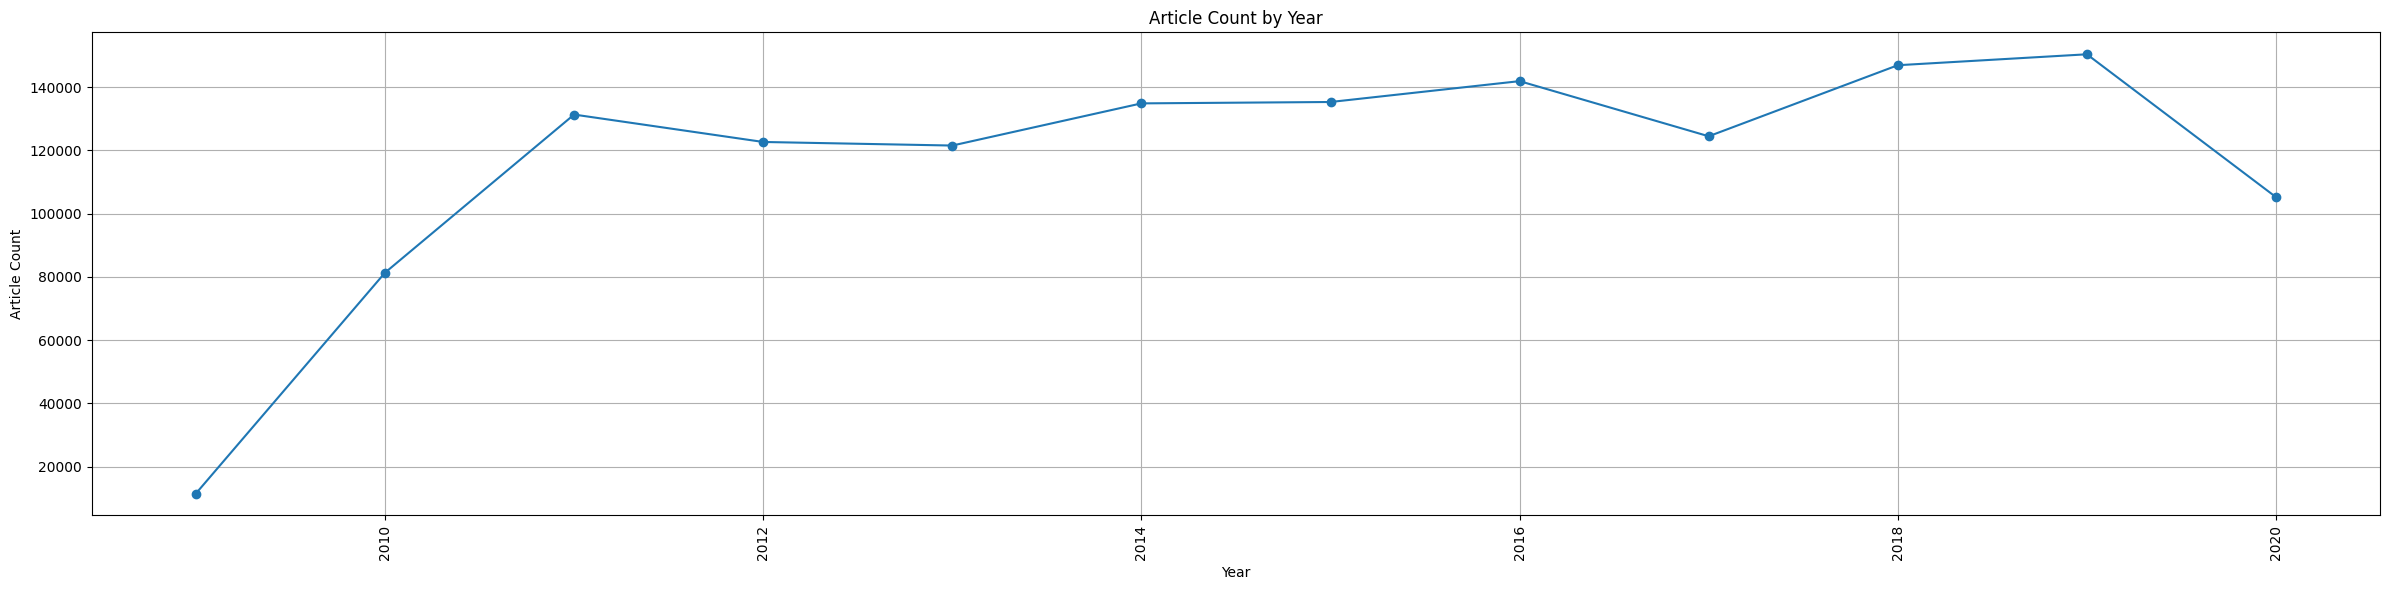

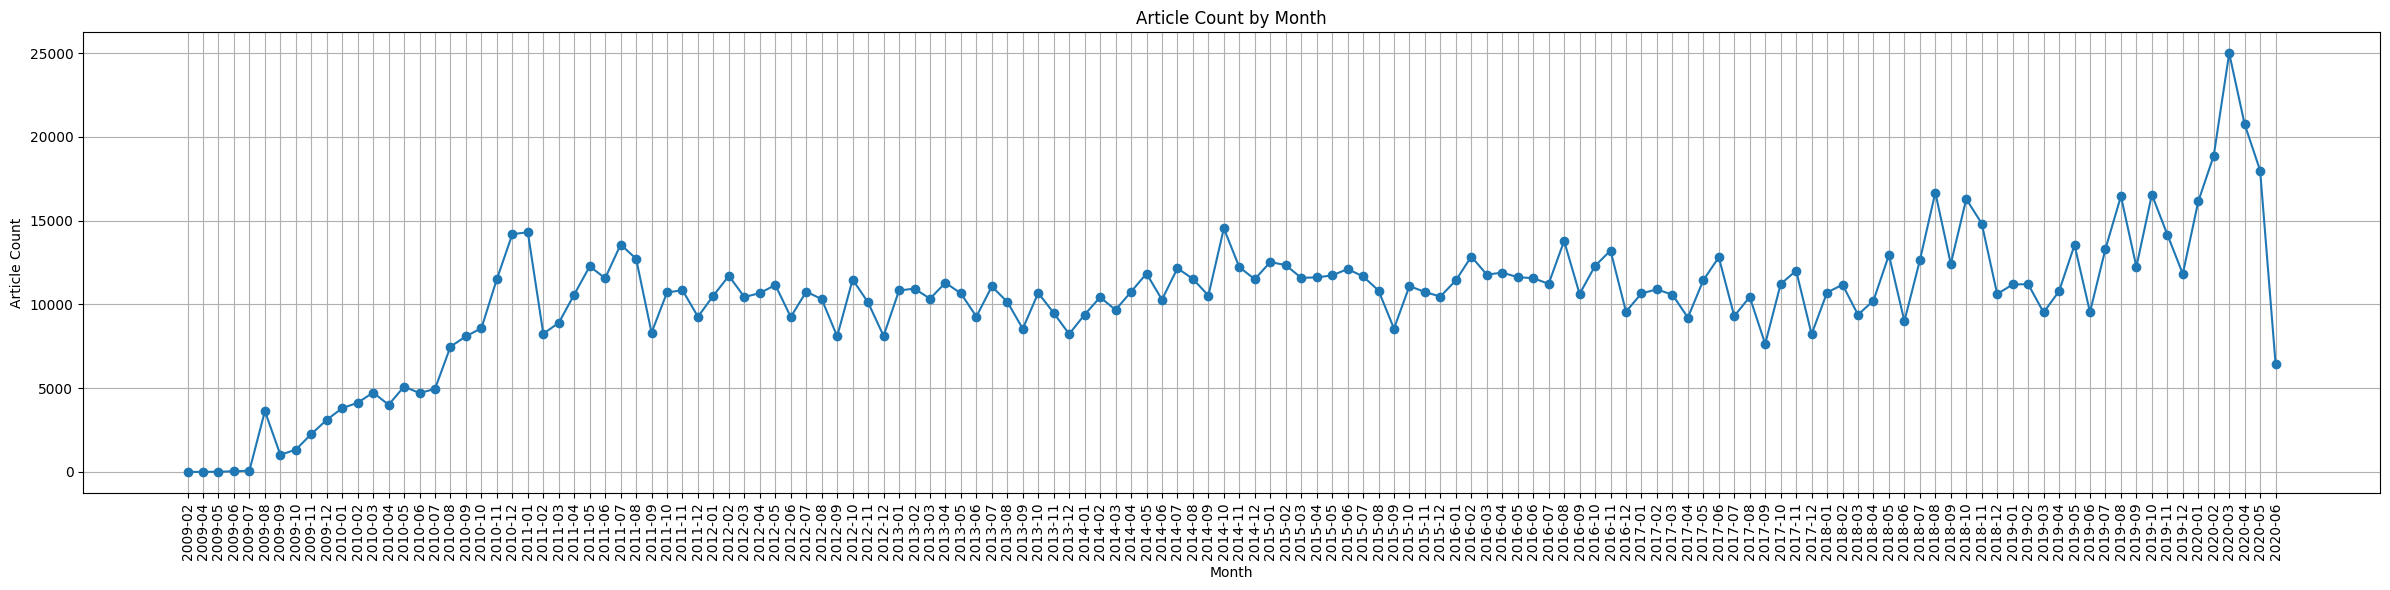

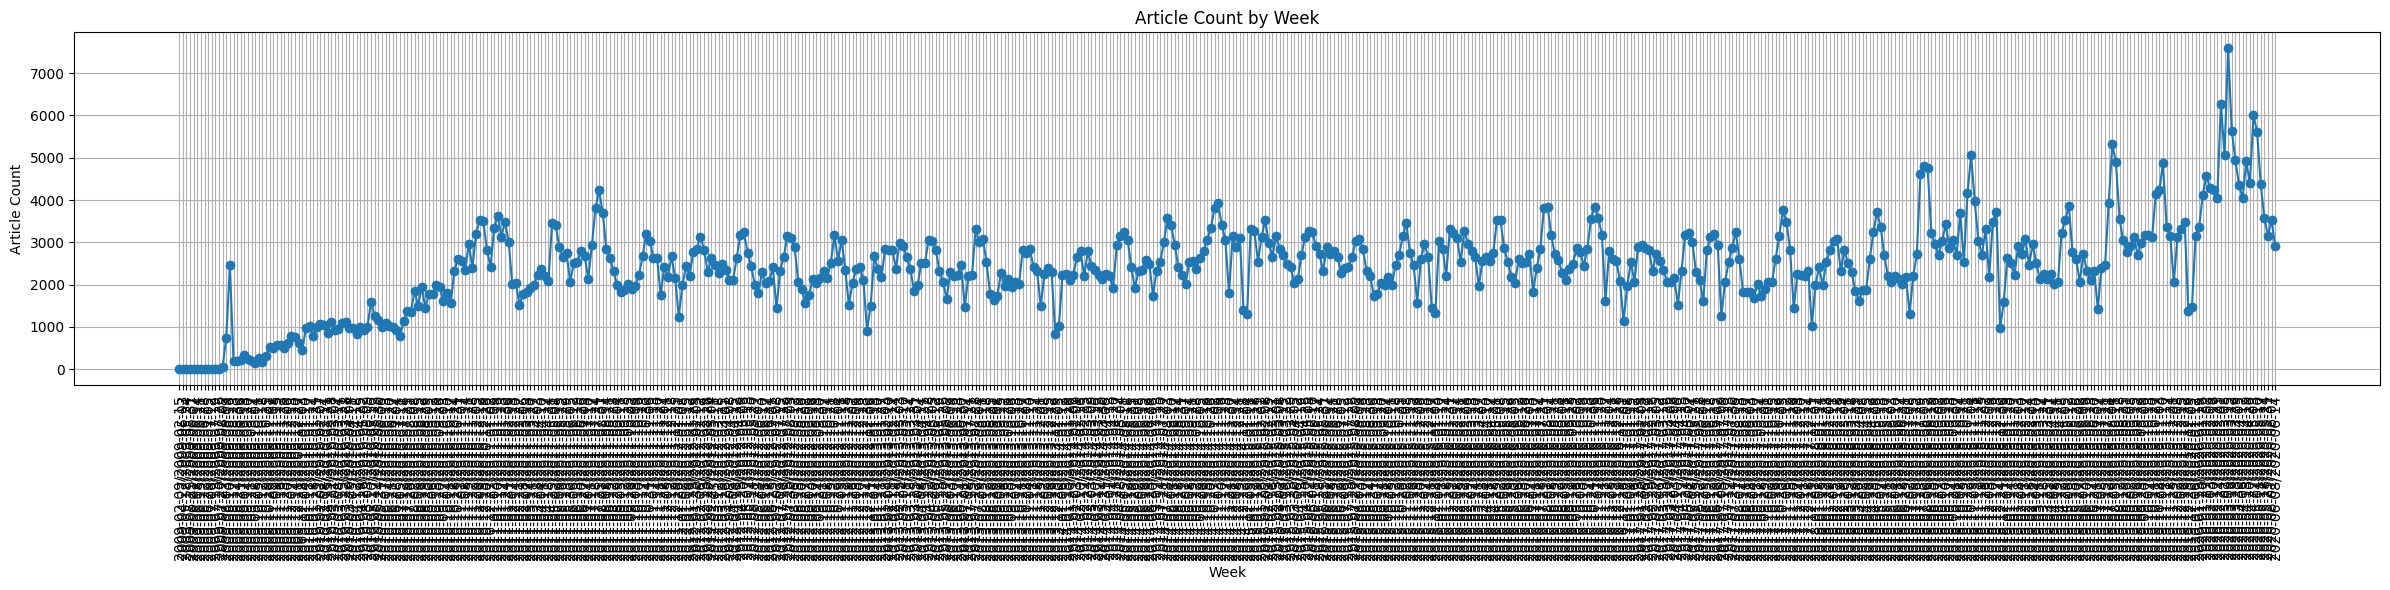

In [16]:
# Time series plots
pt.plot_time_series(df, 'year', 'Article Count by Year', 'Year')
pt.plot_time_series(df, 'month', 'Article Count by Month', 'Month')
pt.plot_time_series(df, 'week', 'Article Count by Week', 'Week')

In [17]:
# Analysis of publishing times might reveal if there’s a specific time when most news is released, which could be crucial for traders and automated trading systems.

df['hour'] = df['date'].dt.hour

hour_counts = df['hour'].value_counts().reset_index()
hour_counts.columns = ['hour', 'article_count']

display(
    "Number of articles per hour",
    hour_counts
)

'Number of articles per hour'

,hour,article_count
0,0,1351408
1,10,7669
2,9,5965
3,12,5732
4,11,5701
5,8,5527
6,7,5033
7,16,3939
8,17,2800
9,13,2710


In [18]:
# Which publishers contribute most to the news feed? Is there a difference in the type of news they report?

publisher_sentiment = df.groupby('publisher')['sentiment'].mean().reset_index()
publisher_sentiment.columns = ['publisher', 'average_sentiment']

publisher_sentiment = publisher_sentiment.sort_values(by='average_sentiment', ascending=False)

display(
    "Publisher sentiment analysis",
    publisher_sentiment.head(10),
    publisher_sentiment.tail(10)
)

'Publisher sentiment analysis'

,publisher,average_sentiment
140,Brett Phillips,1.00
286,Eric Martin,1.00
85,Ben Reynolds,0.80
307,Frank Ochoa,0.80
857,The Professor,0.80
972,giovannimola,0.80
925,White Diamond Research,0.65
356,Happy Trading,0.65
601,Michael Prus,0.60
725,Robert Morris,0.60


,publisher,average_sentiment
45,Andrew Geller,-0.333333
309,Frank Zorrila,-0.350000
36,Alpha Works,-0.400000
522,LeftCoastHedgie,-0.400000
611,Mike Golembesky,-0.400000
586,Maxime Croll,-0.400000
765,ScottKloustin,-0.406250
536,Logan Mohtashami,-0.500000
292,Euro Pacific Capital,-0.500000
792,Spencer James Lawrence,-0.900000


In [19]:
# If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.

results = Parallel(n_jobs=-1)(
    delayed(ut.extract_domain)(email) for email in df['publisher']
)

df['publisher_domain'] = results

publisher_domain_counts = df['publisher_domain'].value_counts().reset_index()
publisher_domain_counts.columns = ['publisher_domain', 'article_count']

display(
    "Publisher domain counts",
    publisher_domain_counts.head(10)
)

'Publisher domain counts'

,publisher_domain,article_count
0,@benzinga.com,7937
1,@gmail.com,139
2,@andyswan.com,5
3,@investdiva.com,2
4,@tothetick.com,2
5,@eosdetroit.io,1
6,@forextraininggroup.com,1
7,@stockmetrix.net,1


The domain analysis reveals that **@benzinga.com** overwhelmingly dominates the dataset, contributing approximately **7,937 articles**, which underscores its role as a **primary and highly active news source** within the collection. This dominance suggests that much of the market-related or financial content in the dataset originates from Benzinga’s editorial output, likely reflecting its consistent publishing frequency and strong influence in financial news dissemination.

In contrast, the presence of **@gmail.com** with around **139 articles** indicates that a small portion of the content may be generated by **independent writers, analysts, or smaller media entities** using personal or non-corporate email domains. This inclusion points to a degree of diversity in authorship, though these individual contributions are significantly less frequent.

Smaller domains such as **@andyswan.com**, **@investdiva.com**, and a few others appear only sporadically, each contributing a negligible number of articles. Their limited presence suggests they represent **niche sources or occasional contributors** rather than consistent news providers.

Overall, the findings highlight a **concentrated distribution of news sources**, where Benzinga functions as the **central hub of content generation**, while independent and lesser-known domains play **supporting or peripheral roles**. This imbalance emphasizes the dataset’s reliance on a single dominant source, which may influence both the **tone and focus of the overall news coverage**.
